In [1]:
# import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import pandas as pd
import librosa

## Obtaining GTZAN dataset

We will be using `deeplake` to get the GTZAN dataset

In [2]:
from IPython.display import clear_output
# deep lake is not part of google colab by default
!pip3 install deeplake

clear_output()

In [3]:
# setting up the deeplake environment, so that we could download it
import os
os.environ['DEEPLAKE_DOWNLOAD_PATH']='./'

In [4]:
import deeplake
ds = deeplake.load("hub://activeloop/gtzan-genre", access_method="local")

-

Opening dataset in read-only mode as you don't have write permissions.


Copying dataset: 0%|          | 0/102 [00:00<?
Copying dataset: 1%|          | 1/102 [00:00<01:13
Copying dataset: 2%|▏         | 2/102 [00:01<01:00
Copying dataset: 3%|▎         | 3/102 [00:01<00:49
Copying dataset: 4%|▍         | 4/102 [00:02<00:44
Copying dataset: 5%|▍         | 5/102 [00:02<00:40
Copying dataset: 6%|▌         | 6/102 [00:02<00:37
Copying dataset: 7%|▋         | 7/102 [00:03<00:34
Copying dataset: 8%|▊         | 8/102 [00:03<00:31
Copying dataset: 9%|▉         | 9/102 [00:03<00:30
Copying dataset: 10%|▉         | 10/102 [00:03<00:31
Copying dataset: 11%|█         | 11/102 [00:04<00:31
Copying dataset: 12%|█▏        | 12/102 [00:04<00:31
Copying dataset: 13%|█▎        | 13/102 [00:05<00:29
Copying dataset: 14%|█▎        | 14/102 [00:05<00:30
Copying dataset: 15%|█▍        | 15/102 [00:05<00:30
Copying dataset: 16%|█▌        | 16/102 [00:06<00:28
Copying dataset: 17%|█▋        | 17/102 [00:06<00:28
Copying dataset: 18%|█▊        | 18/102 [00:06<00:30
Copying dataset: 

./hub_activeloop_gtzan-genre loaded successfully.



## Creating Spectrograms

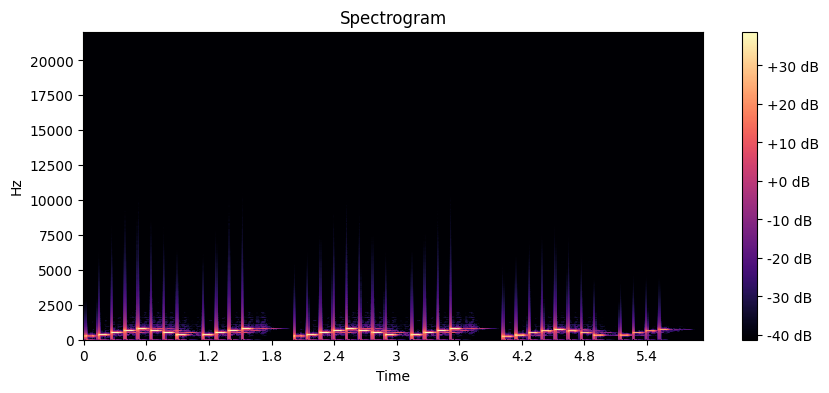

In [13]:
def get_spectrograms():

  audio_file = '/content/file_example_WAV_1MG.wav'
  audio, sample_rate = librosa.load(audio_file, sr=None)
  spectrogram = librosa.stft(audio)
  spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram')
  plt.show()

get_spectrograms()

## Creating Mel-Spectrograms

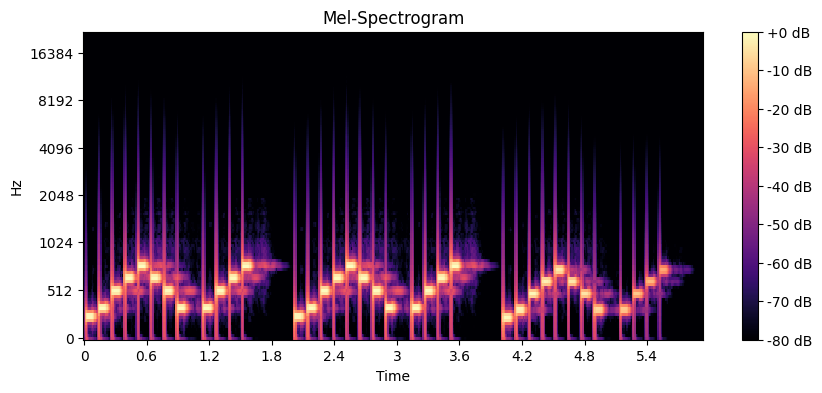

In [17]:
def get_mel_spectrograms():

  audio_file = '/content/file_example_WAV_1MG.wav'
  audio, sample_rate = librosa.load(audio_file, sr=None)
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-Spectrogram')
  plt.show()

get_mel_spectrograms()

In [8]:
# convert .wav to MFCC features
import librosa

def extract_features_mfcc(file_name):
    """
    Extract MFCC features from audio file

    Args:
        file_name (str): path to audio file
    Returns:
        mfccs (np.array): MFCC features
    """
    num_mfcc = 40
    audio, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_mfcc)
    mfccs = mfccs[:, 0:num_mfcc]
    return mfccs

# save mfcc features to an image
import matplotlib.pyplot as plt
import librosa.display

def save_mfcc_image(mfccs, file_name):
    """
    Save MFCC features as an image

    Args:
        mfccs (np.array): MFCC features
        file_name (str): path to save image
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig(file_name)

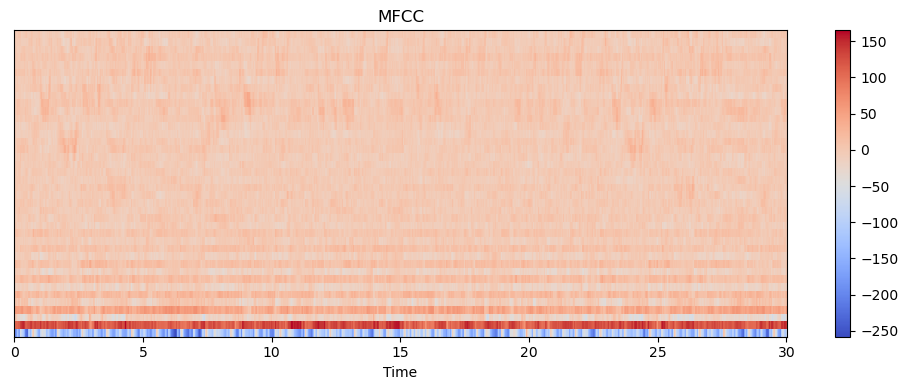

In [9]:
mfcc = extract_features_mfcc('Data/genres_original/blues/blues.00000.wav')
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()